# Trabajo Practico final - Vision por computadora II
## CEIA - FI-UBA
### Integrantes:
- Calabia, Juan Manuel (a2107)
- Cofré, Francisco (a2112)
- Ceballos, Luciano (a2110)
---
## **Dataset elegido:** X-Ray Baggage Scanner Anomaly Detection
### **Origen del dataset:** https://www.kaggle.com/datasets/orvile/x-ray-baggage-anomaly-detection
### **Descripcion del caso de aplicación:** Detección de anomalías en escáneres de rayos X de equipajes mediante aprendizaje profundo. El modelo identifica 5 objetos potencialmente peligrosos: pistola, cuchillo, alicates, tijeras y llave inglesa, lo que facilita la vigilancia inteligente en los sistemas de seguridad de los aeropuertos.

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
#from google.colab import drive

import cv2
from collections import defaultdict, Counter
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Config estilo de las viz
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Config display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

----
## 1. Creacion del dataset de imagenes y analisis exporatorio:

Conteo de imágenes por conjunto:

train: 6197 imágenes
valid: 1766 imágenes
test: 883 imágenes


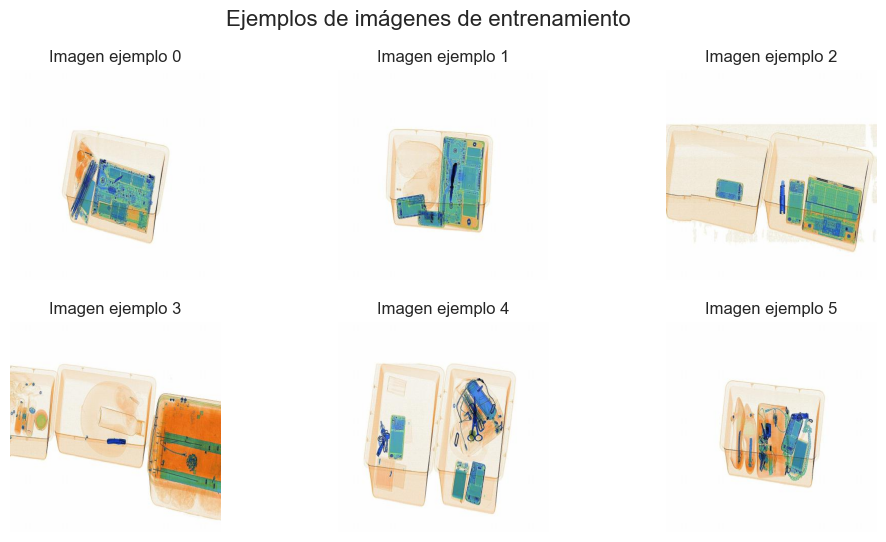


Total de imágenes (train): 6197
Total de etiquetas (train): 6181

Vista previa de las anotaciones:
                                              imagen  clase     x     y  \
0  009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...      2 0.654 0.542   
1  009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...      2 0.558 0.339   
2  009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...      2 0.423 0.380   
3  009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...      2 0.401 0.351   
4  009012_jpg.rf.bc99877ade8754d2be89119361e7820c...      2 0.804 0.387   

   ancho  alto  
0  0.062 0.066  
1  0.055 0.071  
2  0.100 0.055  
3  0.055 0.178  
4  0.053 0.072  


In [18]:
# ===========================
# Montar Google Drive
# ===========================
# drive.mount('/content/drive')

# ===========================
# Rutas base
# ===========================
# BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner")
BASE_DIR = Path("./dataset_baggage_scanner/")
SPLITS = ["train", "valid", "test"]
OBJECT_CLASSES = ['knife', 'firearm', 'pliers', 'scissors', 'wrench']

# ===========================
# Conteo de imágenes por split
# ===========================
print("Conteo de imágenes por conjunto:\n")
for s in SPLITS:
    imgs = list((BASE_DIR / s / "images").rglob("*.jpg")) + list((BASE_DIR / s / "images").rglob("*.png"))
    print(f"{s}: {len(imgs)} imágenes")

# ===========================
# Mostrar ejemplos aleatorios (train)
# ===========================
train_imgs = list((BASE_DIR / "train" / "images").rglob("*.jpg"))
sample_imgs = random.sample(train_imgs, min(6, len(train_imgs)))

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_imgs):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Imagen ejemplo {i}') # 
    plt.axis("off")
plt.suptitle("Ejemplos de imágenes de entrenamiento", fontsize=16)
plt.show()

# ===========================
# Lectura de etiquetas YOLO
# ===========================
IMAGES_DIR = BASE_DIR / "train" / "images"
LABELS_DIR = BASE_DIR / "train" / "labels"

images = sorted(os.listdir(IMAGES_DIR))
labels = sorted(os.listdir(LABELS_DIR))

print(f"\nTotal de imágenes (train): {len(images)}")
print(f"Total de etiquetas (train): {len(labels)}")

# Función para parsear las etiquetas YOLO (formato: class x_center y_center width height)
def parse_label(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            cls, x, y, w, h = map(float, parts)
            data.append([int(cls), x, y, w, h])
    return data

# ===========================
# Crear dataframe con todas las anotaciones
# ===========================
all_data = []
for lbl_file in labels:
    file_path = os.path.join(LABELS_DIR, lbl_file)
    img_name = lbl_file.replace(".txt", ".jpg")
    annotations = parse_label(file_path)
    for ann in annotations:
        cls, x, y, w, h = ann
        all_data.append([img_name, cls, x, y, w, h])

df = pd.DataFrame(all_data, columns=["imagen", "clase", "x", "y", "ancho", "alto"])
print("\nVista previa de las anotaciones:")
print(df.head())


Analisis de la estructura del dataset


,Split,Images,Labels,Missing Labels,Size (MB),% of Data
0,train,6197,6181,16,99.653,70.054
1,valid,1766,1766,0,28.143,19.964
2,test,883,899,0,14.380,9.982
Total,TOTAL,8846,8846,32,142.177,100.000


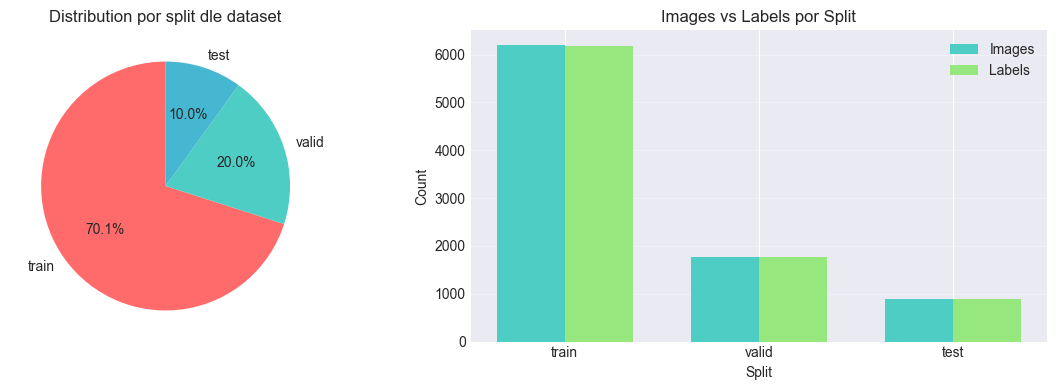

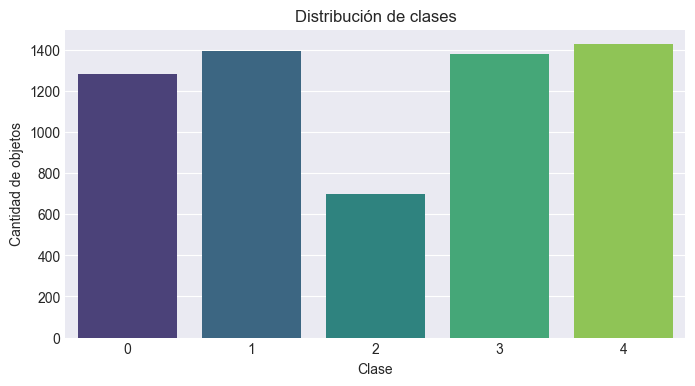

Analisis de calidad de las imagenes

Analizando 300 imagenes para train split...


Procesando train: 100%|██████████| 300/300 [00:04<00:00, 61.58it/s]



Analizando 300 imagenes para valid split...


Procesando valid: 100%|██████████| 300/300 [00:03<00:00, 86.78it/s]



Analizando 300 imagenes para test split...


Procesando test: 100%|██████████| 300/300 [00:03<00:00, 96.13it/s] 


Resumen de estadistica de imagen:


,width,height,aspect_ratio,channels,file_size_kb,brightness,contrast,edge_density
count,900.000,900.000,900.000,900.000,900.000,900.000,900.000,900.000
mean,416.000,416.000,1.000,3.000,16.419,233.677,39.574,0.060
std,0.000,0.000,0.000,0.000,5.078,8.652,8.558,0.024
min,416.000,416.000,1.000,3.000,6.483,201.645,19.303,0.009
25%,416.000,416.000,1.000,3.000,12.179,228.040,33.346,0.041
50%,416.000,416.000,1.000,3.000,15.816,234.510,39.017,0.057
75%,416.000,416.000,1.000,3.000,20.186,240.889,46.103,0.077
max,416.000,416.000,1.000,3.000,32.669,249.688,62.962,0.140



Nro de dimensiones de imangen unicas encontradas: 1

Todas las dimensiones unicas son:
  416x416: 900 images


In [ ]:
def analisis_dataset_estructura():
    """Analisis general de la estructura del dataset"""
    
    dataset_info = {
        'Split': [],
        'Images': [],
        'Labels': [],
        'Missing Labels': [],
        'Size (MB)': []
    }
    
    total_images = 0
    total_labels = 0
    total_size = 0
    
    print("=" * 80)
    print("Analisis de la estructura del dataset")
    print("=" * 80)
    
    for split in SPLITS:
        split_path = BASE_DIR / split
        
        if not split_path.exists():
            continue
            
        images_path = split_path / 'images'
        labels_path = split_path / 'labels'
        
        image_files = list(images_path.glob('*.jpg')) if images_path.exists() else []
        label_files = list(labels_path.glob('*.txt')) if labels_path.exists() else []
        
        # Check de labels faltantes
        image_names = {f.stem for f in image_files}
        label_names = {f.stem for f in label_files}
        missing_labels = image_names - label_names
        
        # Calulcar tamaño
        split_size = sum(f.stat().st_size for f in image_files) / (1024 * 1024)
        
        dataset_info['Split'].append(split)
        dataset_info['Images'].append(len(image_files))
        dataset_info['Labels'].append(len(label_files))
        dataset_info['Missing Labels'].append(len(missing_labels))
        dataset_info['Size (MB)'].append(split_size)
        
        total_images += len(image_files)
        total_labels += len(label_files)
        total_size += split_size
    
    # Crear df
    df_structura = pd.DataFrame(dataset_info)
    
    # Agregar fila acumulado total
    df_structura.loc['Total'] = [
        'TOTAL',
        total_images,
        total_labels,
        df_structure['Missing Labels'].sum(),
        total_size
    ]
    
    # Columna porc.
    df_structura['% of Data'] = (df_structura['Images'] / total_images * 100)
    
    display(df_structura)
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Pie chart por splits
    split_data = df_structura[df_structura['Split'] != 'TOTAL']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    axes[0].pie(split_data['Images'], labels=split_data['Split'], autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes[0].set_title('Distribution por split dle dataset')
    
    # Bar chart para images vs labels
    x = np.arange(len(SPLITS))
    width = 0.35
    axes[1].bar(x - width/2, split_data['Images'], width, label='Images', color='#4ECDC4')
    axes[1].bar(x + width/2, split_data['Labels'], width, label='Labels', color='#95E77E')
    axes[1].set_xlabel('Split')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Images vs Labels por Split')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(SPLITS)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


    # Análisis de distribución de clases
    # ===========================
    plt.figure(figsize=(8, 4))
    sns.countplot(x="clase", data=df, palette="viridis")
    plt.title("Distribución de clases")
    plt.xlabel("Clase")
    plt.ylabel("Cantidad de objetos")
    plt.show()
    
    return df_structure

df_structure = analisis_dataset_estructura()


# Analisis de las propiedades de las imagenes
def analizar_imagen_propiedades(sample_size=500):
    """Analizar propiedades de las imagenes incluyendo dimensiones, canales y calidad"""
    
    print("=" * 80)
    print("Analisis de calidad de las imagenes")
    print("=" * 80)
    
    all_stats = []
    
    for split in SPLITS:
        images_path = BASE_DIR / split / 'images'
        if not images_path.exists():
            continue
            
        image_files = list(images_path.glob('*.jpg'))
        
        # Se trabaja con una muestra
        image_files = np.random.choice(image_files, sample_size, replace=False)
        
        print(f"\nAnalizando {len(image_files)} imagenes para {split} split...")
        
        for img_path in tqdm(image_files, desc=f"Procesando {split}"):
            try:
                # Abrir con PIL para stats basicas
                img_pil = Image.open(img_path)
                width, height = img_pil.size
                mode = img_pil.mode
                
                # Abrir con OpenCV para stats avanzadas
                img_cv = cv2.imread(str(img_path))
                
                if img_cv is not None:
                    # Obtener canales
                    channels = 1 if len(img_cv.shape) == 2 else img_cv.shape[2]
                    
                    # Convertir a estala grises
                    gray = cv2 .cvtColor(img_cv, cv2.COLOR_BGR2GRAY) if channels > 1 else img_cv
                    
                    # Calcular metricas
                    brightness = np.mean(gray)
                    contrast = np.std(gray)
                    
                    # Densidad de bordes usando Canny 
                    edges = cv2.Canny(gray, 50, 150)
                    edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
                    
                    all_stats.append({
                        'split': split,
                        'filename': img_path.name,
                        'width': width,
                        'height': height,
                        'aspect_ratio': width / height,
                        'channels': channels,
                        'file_size_kb': img_path.stat().st_size / 1024,
                        'brightness': brightness,
                        'contrast': contrast,
                        'edge_density': edge_density
                    })
                    
            except Exception as e:
                print(f"  Error al procesar {img_path.name}: {e}")
    
    # Crear df
    df_images = pd.DataFrame(all_stats)
    
    # Display estadisticas
    print("\nResumen de estadistica de imagen:")
    display(df_images.describe())
    
    # Check para dimensiones unicas, se deja la opcion por si se agregan mas imagenes con otras dimensiones
    unique_dims = df_images[['width', 'height']].drop_duplicates()
    print(f"\nNro de dimensiones de imangen unicas encontradas: {len(unique_dims)}")
    
    if len(unique_dims) <= 10:
        print("\nTodas las dimensiones unicas son:")
        for _, row in unique_dims.iterrows():
            count = len(df_images[(df_images['width'] == row['width']) & 
                                 (df_images['height'] == row['height'])])
            print(f"  {int(row['width'])}x{int(row['height'])}: {count} images")
    else:
        print("\n Top 5 dimensiones mas comunes:")
        dim_counts = df_images.groupby(['width', 'height']).size().sort_values(ascending=False)
        for dims, count in dim_counts.head().items():
            print(f"  {int(dims[0])}x{int(dims[1])}: {count} images")
    
    return df_images

df_images = analizar_imagen_propiedades(sample_size=300)


Conclusiones:
- La clase 2 parace estar submuestrada (clase minoritaria), a la hora de entrenar hacerlo aplicando ajuste de pesos o hacer oversampling con SMOTE. Prestar especial atencion a las metricas sobre la clase 2 (F-1, precision y recall). 
- Todas las imagenes del dataset son denticas desde el punto de vista de las dimensiones.
- Todas las imagenes son RGB (3 canales).
- El brillo es elevado, en promedio es de 233.6 y el minimo es de 201. Esto indica que si el modelo va a necesitar funcionar en condiciones de poca luz podría ser un riesgo.
- La densidad de bordes es favorable para entrenar un modelo, entre un 0.9% y un 14%, lo que indica variedad. 

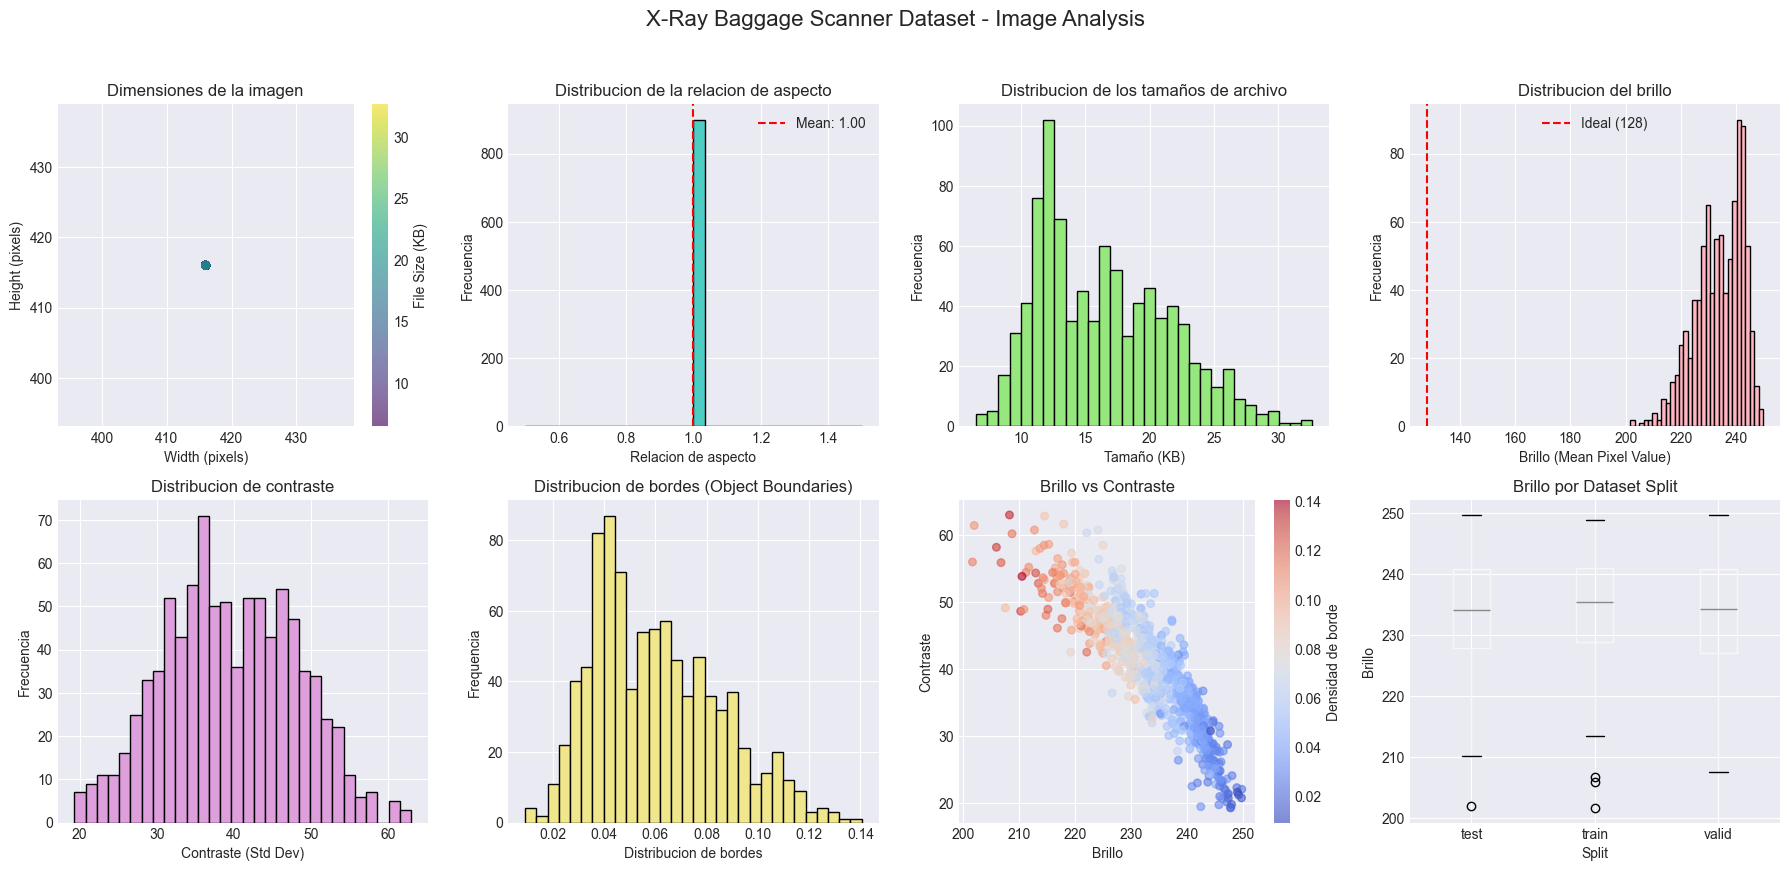

In [ ]:
# Visualization de las propiedades de la imagen
def visualizar_propiedades_imagen(df_images):
    """Visualizar propiedades de las imagenes"""
    
    fig = plt.figure(figsize=(18, 12))
    
    # scatter plot para las dimensiones
    ax1 = plt.subplot(3, 4, 1)
    scatter = ax1.scatter(df_images['width'], df_images['height'], 
                         c=df_images['file_size_kb'], cmap='viridis', 
                         alpha=0.6, s=30)
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Height (pixels)')
    ax1.set_title('Dimensiones de la imagen')
    plt.colorbar(scatter, ax=ax1, label='File Size (KB)')
    
    # 2. Distribucion de la relacion de aspecto
    ax2 = plt.subplot(3, 4, 2)
    ax2.hist(df_images['aspect_ratio'], bins=30, edgecolor='black', color='#4ECDC4')
    ax2.axvline(df_images['aspect_ratio'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_images["aspect_ratio"].mean():.2f}')
    ax2.set_xlabel('Relacion de aspecto')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Distribucion de la relacion de aspecto')
    ax2.legend()
    
    # 3. Distribucion del tamaño
    ax3 = plt.subplot(3, 4, 3)
    ax3.hist(df_images['file_size_kb'], bins=30, edgecolor='black', color='#95E77E')
    ax3.set_xlabel('Tamaño (KB)')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribucion de los tamaños de archivo')
    
    # 4. Distribucion del brillo
    ax4 = plt.subplot(3, 4, 4)
    ax4.hist(df_images['brightness'], bins=30, edgecolor='black', color='#FFB6C1')
    ax4.axvline(128, color='red', linestyle='--', label='Ideal (128)')
    ax4.set_xlabel('Brillo (Mean Pixel Value)')
    ax4.set_ylabel('Frecuencia')
    ax4.set_title('Distribucion del brillo')
    ax4.legend()
    
    # 5. Contrast distribution
    ax5 = plt .subplot(3, 4, 5)
    ax5 .hist(df_images['contrast'], bins=30, edgecolor='black', color='#DDA0DD')
    ax5 .set_xlabel('Contraste (Std Dev)')
    ax5 .set_ylabel('Frecuencia')
    ax5 .set_title('Distribucion de contraste')
    
    # 6. Distribucion de la densidad de bordes
    ax6 = plt.subplot(3, 4, 6)
    ax6.hist(df_images['edge_density'], bins=30, edgecolor='black', color='#F0E68C')
    ax6.set_xlabel('Distribucion de bordes')
    ax6.set_ylabel('Frequencia')
    ax6.set_title('Distribucion de bordes (Object Boundaries)')
    
    # 7. Brillo vs Contraste scatter
    ax7 = plt.subplot(3, 4, 7)
    scatter2 = ax7 .scatter(df_images['brightness'], df_images['contrast'], 
                          c=df_images['edge_density'], cmap='coolwarm', 
                          alpha=0.6, s=30)
    ax7.set_xlabel('Brillo')
    ax7.set_ylabel('Contraste')
    ax7.set_title('Brillo vs Contraste')
    plt.colorbar(scatter2, ax=ax7, label='Densidad de borde')
    
    # 8. Box plots por split
    ax8 = plt.subplot(3, 4, 8)
    df_images.boxplot(column='brightness', by='split', ax=ax8)
    ax8.set_xlabel('Split')
    ax8.set_ylabel('Brillo')
    ax8.set_title('Brillo por Dataset Split')
    plt.sca(ax8)
    plt.xticks(rotation=0)
    
    
    
    plt.suptitle('X-Ray Baggage Scanner Dataset - Image Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

visualizar_propiedades_imagen(df_images)


Conclusiones: 
- Todas las imagenes son cuadradas, ninguna es rectangular; el dataset esta normalizado y no es necesario aplicar redimensionamiento ni relleno -padding-.
- Con respecto a la distribucion del brillo, tal como se mencionó anteriormente el dataset tiene imagenes muy brillantes, el modelo debe trabajar con imagenes de este tipo. 
- Con respecto a la distribucion de contraste, la mayoría esta cerca del promedio pero tambien existen imagenes con reducido y elevados valores; esto va a generar un modelo robusto.
- La distribucion de bordes indica que las imagenes son en su mayoria relativamente simples, aunque existe una considerable cantidad de imagenes "texturizadas".

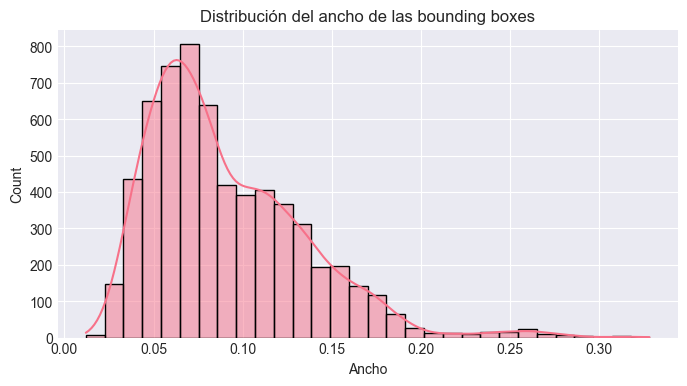

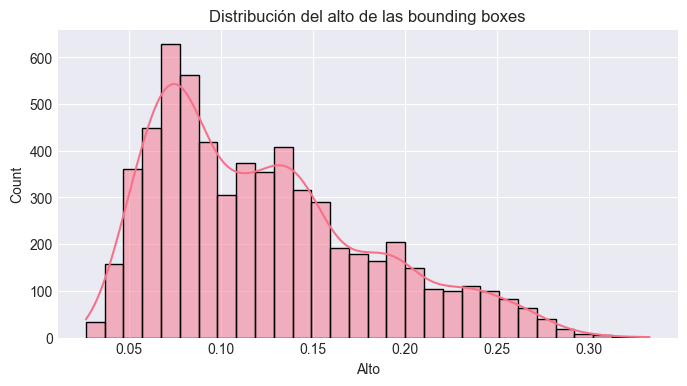

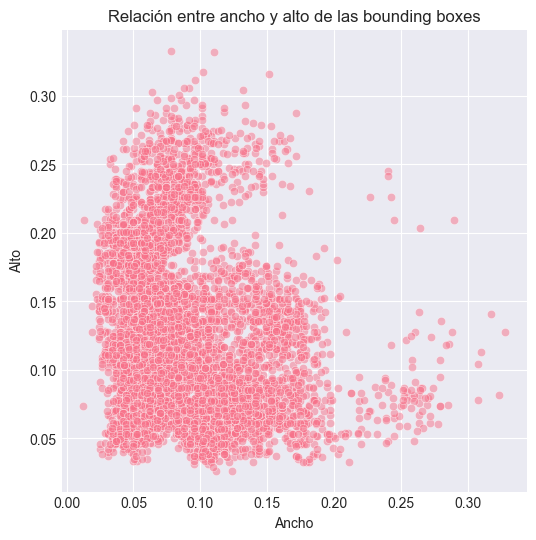


📈 Resumen estadístico de las cajas:
         ancho     alto
count 6181.000 6181.000
mean     0.091    0.124
std      0.044    0.059
min      0.012    0.026
25%      0.058    0.076
50%      0.081    0.112
75%      0.117    0.157
max      0.328    0.333
Analisis de labels (formato YOLO)

Analizando 6181 label del split train ...


Procesando train labels: 100%|██████████| 6181/6181 [00:03<00:00, 2013.30it/s]



Analizando 1766 label del split valid ...


Procesando valid labels: 100%|██████████| 1766/1766 [00:00<00:00, 2794.49it/s]



Analizando 899 label del split test ...


Procesando test labels: 100%|██████████| 899/899 [00:00<00:00, 2043.44it/s]


  Distribucion de clases:
  wrench      :  2025 ( 22.9%)
  firearm     :  1975 ( 22.3%)
  scissors    :  1948 ( 22.0%)
  knife       :  1857 ( 21.0%)
  pliers      :  1041 ( 11.8%)

 Ratio desbalanceo de clases: 1.95

 Stats de objetos por imagen:
  train:
    Imagenes con objetos: 6181
    Imagenes sin objetos: 0
    Avg de objetos por imagen: 1.00
    Max objetos por imagen: 1
  valid:
    Imagenes con objetos: 1766
    Imagenes sin objetos: 0
    Avg de objetos por imagen: 1.00
    Max objetos por imagen: 1
  test:
    Imagenes con objetos: 899
    Imagenes sin objetos: 0
    Avg de objetos por imagen: 1.00
    Max objetos por imagen: 1

 Bounding Box Stats:
  Area - Min: 0.0009, Max: 0.0606, Mean: 0.0107
  Aspect Ratio - Min: 0.03, Max: 7.18, Mean: 0.98


In [36]:
# 6. Analisis de Label  (Formato YOLO )
# ===========================
# Análisis de tamaños de bounding boxes
# ===========================
plt.figure(figsize=(8, 4))
sns.histplot(df["ancho"], bins=30, kde=True)
plt.title("Distribución del ancho de las bounding boxes")
plt.xlabel("Ancho")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["alto"], bins=30, kde=True)
plt.title("Distribución del alto de las bounding boxes")
plt.xlabel("Alto")
plt.show()

# ===========================
# Relación entre ancho y alto
# ===========================
plt.figure(figsize=(6, 6))
sns.scatterplot(x="ancho", y="alto", data=df, alpha=0.5)
plt.title("Relación entre ancho y alto de las bounding boxes")
plt.xlabel("Ancho")
plt.ylabel("Alto")
plt.show()

# ===========================
# Resumen estadístico
# ===========================
print("\n📈 Resumen estadístico de las cajas:")
print(df[["ancho", "alto"]].describe())



def analisis_yolo_labels():
    #Analizar labels formato YOLO
    
    print("=" * 80)
    print("Analisis de labels (formato YOLO)")
    print("=" * 80)
    
    all_annotations = []
    images_with_objects = defaultdict(int)
    objects_per_image = defaultdict(list)
    
    for split in SPLITS:
        labels_path = BASE_DIR / split / 'labels'
        if not labels_path.exists():
            continue
            
        label_files = list(labels_path.glob('*.txt'))
        print(f"\nAnalizando {len(label_files)} label del split {split} ...")
        
        for label_file in tqdm(label_files, desc=f"Procesando {split} labels"):
            image_name = label_file.stem
            
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            if len(lines) == 0:
                # Empty label file 
                objects_per_image[split].append(0)
            else:
                images_with_objects[split] += 1
                objects_per_image[split].append(len(lines))
                
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        class_name = OBJECT_CLASSES[class_id] if class_id < len(OBJECT_CLASSES) else f"Unknown_{class_id}"
                        
                        all_annotations.append({
                            'split': split,
                            'image': image_name,
                            'class_id': class_id,
                            'class_name': class_name,
                            'x_center': x_center,
                            'y_center': y_center,
                            'bbox_width': width,
                            'bbox_height': height,
                            'bbox_area': width * height,
                            'bbox_aspect_ratio': width / height if height > 0 else 0
                        })
    
    # Crear df
    df_labels = pd.DataFrame(all_annotations)
    
    if len(df_labels) == 0:
        print(" empty file")
        return None
    
    # Distribucion de clases
    print("\n  Distribucion de clases:")
    class_counts = df_labels['class_name'].value_counts()
    for class_name, count in class_counts.items():
        percentage = (count / len(df_labels)) * 100
        print(f"  {class_name:12s}: {count:5d} ({percentage:5.1f}%)")
    
    # Desbalanceo de clases
    if len(class_counts) > 1:
        imbalance_ratio = class_counts.max() / class_counts.min()
        print(f"\n Ratio desbalanceo de clases: {imbalance_ratio:.2f}")
        if imbalance_ratio > 3:
            print("   Alto desbalanceo de clases, aplicar data augmentation es prioritario.")
    
    # Stats de objetos por imagen
    print("\n Stats de objetos por imagen:")
    for split in SPLITS:
        if split in objects_per_image:
            objs = objects_per_image[split]
            if objs:
                print(f"  {split}:")
                print(f"    Imagenes con objetos: {images_with_objects[split]}")
                print(f"    Imagenes sin objetos: {len(objs) - images_with_objects[split]}")
                print(f"    Avg de objetos por imagen: {np.mean(objs):.2f}")
                print(f"    Max objetos por imagen: {max(objs)}")
    
    # Stats Bounding box 
    print("\n Bounding Box Stats:")
    print(f"  Area - Min: {df_labels['bbox_area'].min():.4f}, "
          f"Max: {df_labels['bbox_area'].max():.4f}, "
          f"Mean: {df_labels['bbox_area'].mean():.4f}")
    print(f"  Aspect Ratio - Min: {df_labels['bbox_aspect_ratio'].min():.2f}, "
          f"Max: {df_labels['bbox_aspect_ratio'].max():.2f}, "
          f"Mean: {df_labels['bbox_aspect_ratio'].mean():.2f}")
    
    return df_labels, objects_per_image

df_labels, objects_per_image = analisis_yolo_labels()


Conclusiones: 
- Todas las imagenes tienen solo 1 objeto, esto implica que el modelo no va a tener que preocuparse por encontrar cuantos objetos hay sino que tiene que identificar el unico que hay.
- Los objetos son pequeños (ver reducida area del bounding box), trabajar con modelos que sean buenos manejando objetos pequeños.
- Relacion de aspecto en general cercaa a 1, los objetos son casi cuadrados; pero existen extremos que indican formas de objetos muy anchos o muy cortos.

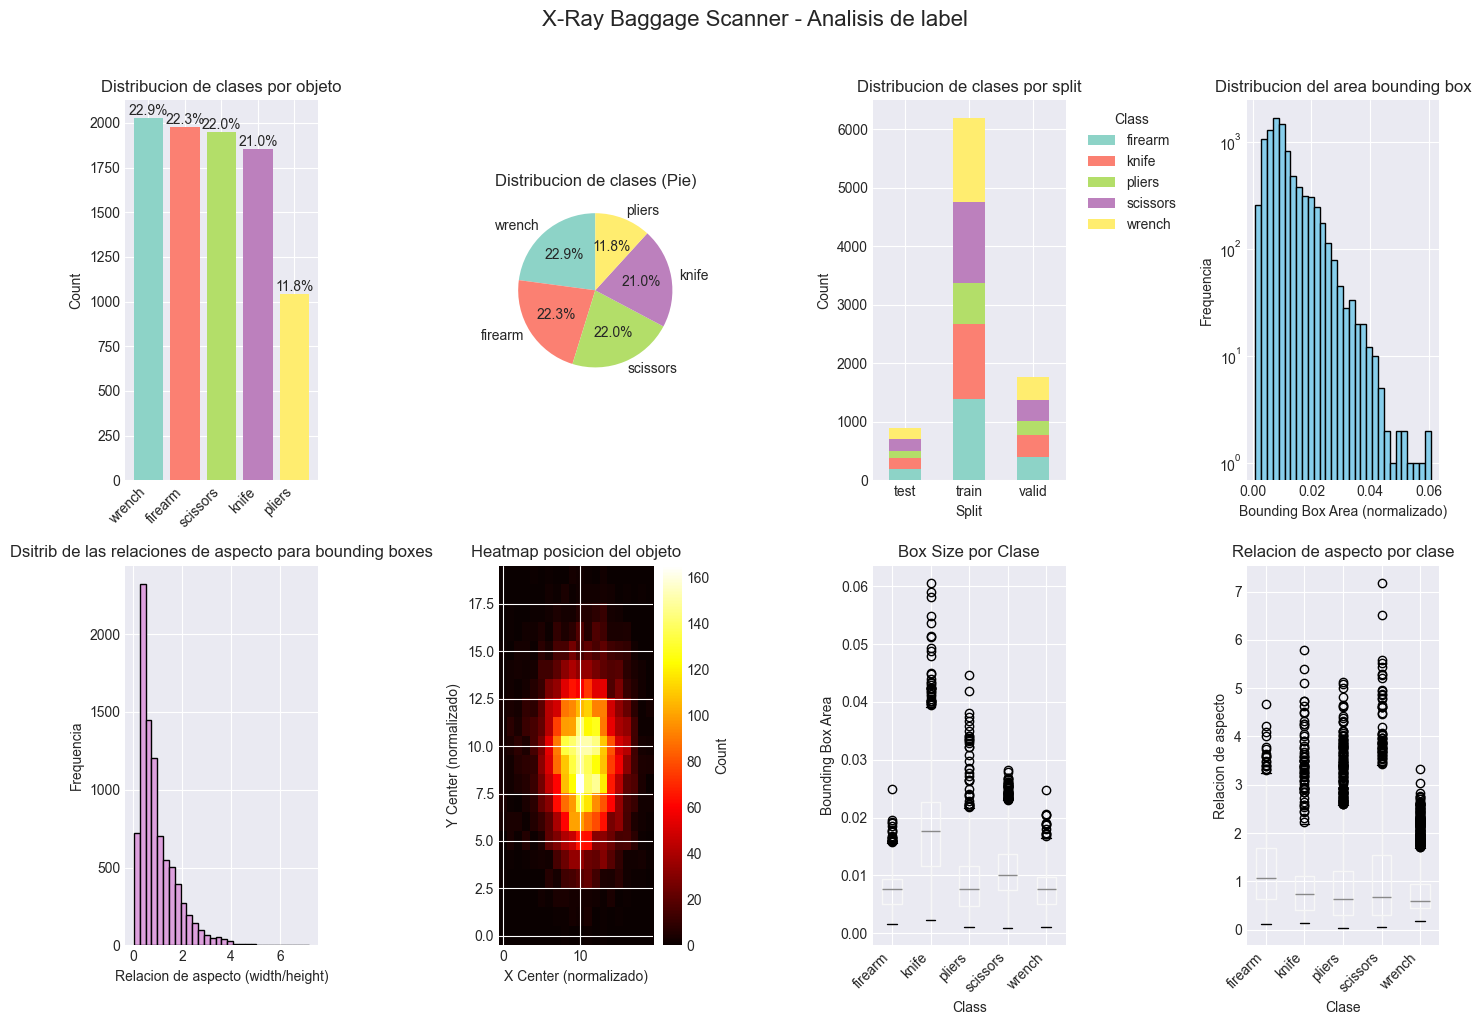

In [ ]:
# 7. Label Viz
def visualize_label_analysis(df_labels):
    #Analisis de label - visualizaciones
    
    fig = plt.figure(figsize=(14, 10))
    
    # 1. bar chart de distribucion de clases
    ax1 = plt.subplot(2, 4, 1)
    class_counts = df_labels['class_name'] .value_counts()
    colors = plt .cm .Set3(np .linspace(0, 1, len(class_counts)))
    bars = ax1 .bar(range(len(class_counts)), class_counts.values, color=colors)
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribucion de clases por objeto')
    
    # Agergar pct labels
    for i, (bar, count) in enumerate(zip(bars, class_counts.values)):
        percentage = (count / len(df_labels)) * 100
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{percentage:.1f}%', ha='center', va='bottom')
    
    # 2. pie chart distribucion de clases
    ax2 = plt.subplot(2, 4, 2)
    ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
    ax2.set_title('Distribucion de clases (Pie)')
    
    # 3. Distribucion de clases por split
    ax3 = plt.subplot(2, 4, 3)
    split_class_counts = df_labels.groupby(['split', 'class_name']).size().unstack(fill_value=0)
    split_class_counts.plot(kind='bar', stacked=True, ax=ax3, colormap='Set3')
    ax3.set_xlabel('Split')
    ax3.set_ylabel('Count')
    ax3.set_title('Distribucion de clases por split')
    ax3.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)
    
    # 4. Distribucion del area de bounding box
    ax4 = plt.subplot(2, 4, 4)
    ax4.hist(df_labels['bbox_area'], bins=30, edgecolor='black', color='#87CEEB')
    ax4.set_xlabel('Bounding Box Area (normalizado)')
    ax4.set_ylabel('Frequencia')
    ax4.set_title('Distribucion del area bounding box')
    ax4.set_yscale('log')
    
    # 5. Ratio bounding box 
    ax5 = plt.subplot(2, 4, 5)
    ax5.hist(df_labels['bbox_aspect_ratio'], bins=30, edgecolor='black', color='#DDA0DD')
    ax5.set_xlabel('Relacion de aspecto (width/height)')
    ax5.set_ylabel('Frequencia')
    ax5.set_title('Dsitrib de las relaciones de aspecto para bounding boxes')
    
    # 6. heatmap posicion del objeto
    ax6 = plt.subplot(2, 4, 6)
    heatmap, xedges, yedges = np.histogram2d(df_labels['x_center'], 
                                             df_labels['y_center'], bins=20)
    im = ax6.imshow(heatmap.T, origin='lower', cmap='hot', aspect='auto')
    ax6.set_xlabel('X Center (normalizado)')
    ax6.set_ylabel('Y Center (normalizado)')
    ax6.set_title('Heatmap posicion del objeto')
    plt.colorbar(im, ax=ax6, label='Count')
    
    # 7. Box size por class
    ax7 = plt.subplot(2, 4, 7)
    df_labels.boxplot(column='bbox_area', by='class_name', ax=ax7)
    ax7.set_xlabel('Class')
    ax7.set_ylabel('Bounding Box Area')
    ax7.set_title('Box Size por Clase')
    plt.sca(ax7)
    plt.xticks(rotation=45, ha='right')
    
    # 8. Relacion de aspecto por clase
    ax8 = plt.subplot(2, 4, 8)
    df_labels.boxplot(column='bbox_aspect_ratio', by='class_name', ax=ax8)
    ax8.set_xlabel('Clase')
    ax8.set_ylabel('Relacion de aspecto')
    ax8.set_title('Relacion de aspecto por clase')
    plt.sca(ax8)
    plt.xticks(rotation=45, ha='right')
    
    plt.suptitle('X-Ray Baggage Scanner - Analisis por labels', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

visualize_label_analysis(df_labels)

Conclusiones:
- El objeto esta en su gran mayoria en el centro de la imagen.
- La clase pliers es la clase con menor proporcion en los 3 splits; esto significa que las metricas de validacion y test son un reflejo fiel del problema.

----

In [ ]:
# Instalar dependencias
import torch
print("Torch:", torch.__version__, " | CUDA disponible:", torch.cuda.is_available())


Torch: 2.8.0+cu126  | CUDA disponible: True


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
# Definir ruta del data set
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner')

print("Existe:", DATA_DIR.exists())

# Listar contenido
!ls -lha "/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Existe: True
total 14K
-rw------- 1 root root  364 Nov  5 17:10 data.yaml
-rw------- 1 root root  160 Apr 12  2025 README.dataset.txt
-rw------- 1 root root 1006 Apr 12  2025 README.roboflow.txt
drwx------ 4 root root 4.0K Nov  2 15:10 test
drwx------ 4 root root 4.0K Nov  2 15:10 train
drwx------ 4 root root 4.0K Nov  2 15:10 valid


In [ ]:
# Verificar estructura y actualizar data.yaml
import yaml

yaml_path = DATA_DIR / "data.yaml"

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

data["path"] = str(DATA_DIR)

with open(yaml_path, "w") as f:
    yaml.dump(data, f)

print("data.yaml actualizado:")
print(data)



data.yaml actualizado:
{'names': ['0', '1', '2', '3', '4'], 'nc': 5, 'path': '/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner', 'roboflow': {'license': 'CC BY 4.0', 'project': 'x-ray-baggage-detection', 'url': 'https://universe.roboflow.com/malek-mhnrl/x-ray-baggage-detection/dataset/1', 'version': 1, 'workspace': 'malek-mhnrl'}, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}


Imágenes en train: 6197
Usando imagen de ejemplo: /content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner/train/images/037386_jpg.rf.7d6fea56091733f18e0cdfeda87f04f1.jpg


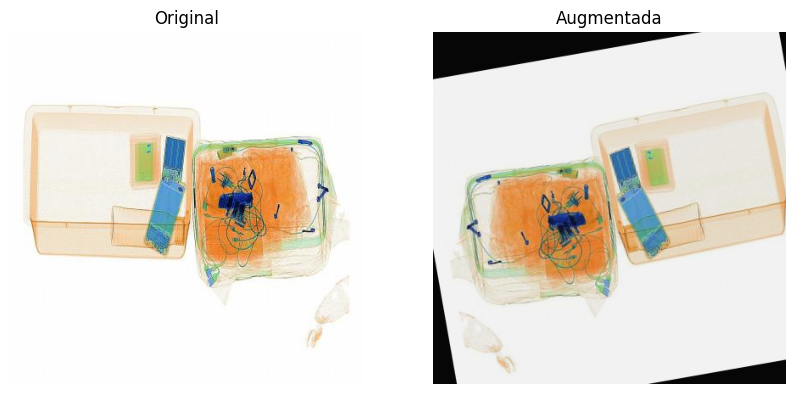

In [ ]:
# Data augmentation + manejo de errores
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Buscar imágenes en train/valid/test (si no existe sample_imgs)
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner')

train_images = list((DATA_DIR / "train" / "images").rglob("*.jpg")) + list((DATA_DIR / "train" / "images").rglob("*.png"))

print("Imágenes en train:", len(train_images))
if len(train_images) == 0:
    # fallback: buscar en todo el dataset
    all_imgs = list(DATA_DIR.rglob("*.jpg")) + list(DATA_DIR.rglob("*.png"))
    print("Imágenes totales encontradas (fallback):", len(all_imgs))
    if len(all_imgs) == 0:
        raise RuntimeError("No se encontraron imágenes en el dataset. Revisá DATA_DIR.")
    sample_img_path = str(all_imgs[0])
else:
    sample_img_path = str(random.choice(train_images))

print("Usando imagen de ejemplo:", sample_img_path)

# Defino augmentaciones válidas (sin parámetros inválidos)
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.03, scale=(0.92, 1.08), rotate=10, p=0.6),  # reemplaza ShiftScaleRotate
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
    A.Blur(blur_limit=3, p=0.2),
    A.CoarseDropout(p=0.2),  # simple, sin params que provoquen warning
])

# Leer imagen (cv2 devuelve BGR)
img = cv2.imread(sample_img_path)
if img is None:
    raise RuntimeError(f"No se pudo leer la imagen: {sample_img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Aplicar augment y mostrar
augmented = aug(image=img)['image']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Augmentada")
plt.imshow(augmented)
plt.axis("off")
plt.show()



In [ ]:
# =======================
# ENTRENAMIENTO YOLOv8
# =======================

!pip install ultralytics -q

from ultralytics import YOLO
from pathlib import Path
import shutil
import torch
from google.colab import drive
import os
import glob

# ===========================
# Montar Google Drive
# ===========================
drive.mount('/content/drive')

# ===========================
# Configuración de rutas
# ===========================
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks")
DATA_DIR = BASE_DIR / "dataset_baggage_scanner"
MODEL_DIR = BASE_DIR / "modelos"
MODEL_PATH = MODEL_DIR / "baggage_yolov8n_debug.pt"
RUNS_DIR = BASE_DIR / "runs/train/baggage_yolov8n_debug"
LOCAL_DATA = Path("/content/dataset_baggage_scanner")

# ===========================
# Verificar GPU
# ===========================
print("GPU disponible:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

if not torch.cuda.is_available():
    print("No tenés GPU activada. Andá a 'Entorno de ejecución → Cambiar tipo de entorno de ejecución' y elegí GPU antes de continuar.")
else:
    print("Entrenamiento acelerado por GPU listo.")

# ===========================
# Copiar dataset local
# ===========================
if not LOCAL_DATA.exists():
    shutil.copytree(DATA_DIR, LOCAL_DATA)
    print("Dataset copiado a almacenamiento local.")
else:
    print("Dataset ya presente en almacenamiento local.")

# ===========================
# Cargar o entrenar modelo
# ===========================
if MODEL_PATH.exists():
    print(f"Modelo encontrado en {MODEL_PATH}, cargando sin entrenar...")
    model = YOLO(MODEL_PATH)
else:
    print("No se encontró modelo entrenado, iniciando entrenamiento...")

    # Borrar runs anteriores para que no duplique nombres
    if RUNS_DIR.exists():
        shutil.rmtree(RUNS_DIR)

    model = YOLO("yolov8n.pt")  # modelo base pequeño

    results = model.train(
        data=str(LOCAL_DATA / "data.yaml"),
        epochs=50,
        imgsz=640,
        batch=8,
        name="baggage_yolov8n_debug",
        project=str(BASE_DIR / "runs/train"),  # carpeta fija
        exist_ok=True,  # evita crear baggage_yolov8n_debug2, etc.
        device=0  # fuerza uso de GPU
    )

    # ==============================
    # Guardar el mejor modelo
    # ==============================
    best_model = RUNS_DIR / "weights" / "best.pt"
    if best_model.exists():
        MODEL_DIR.mkdir(parents=True, exist_ok=True)
        shutil.copy(best_model, MODEL_PATH)
        print(f"Modelo copiado y guardado en: {MODEL_PATH}")
    else:
        print("No se encontró el archivo best.pt luego del entrenamiento.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU disponible: True
Dispositivo: Tesla T4
Entrenamiento acelerado por GPU listo.
Dataset ya presente en almacenamiento local.
Modelo encontrado en /content/drive/MyDrive/Colab Notebooks/modelos/baggage_yolov8n_debug.pt, cargando sin entrenar...


In [ ]:
# Evaluación del modelo
metrics = model.val(data=str(DATA_DIR / "data.yaml"), imgsz=640)
print("📊 Métricas finales:")
print(metrics)


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.7 ms, read: 7.3±4.2 MB/s, size: 19.4 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner/valid/labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1766/1766 235.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 111/111 3.0it/s 37.2s
                   all       1766       1766      0.618      0.536      0.561      0.236
                     0        391        391      0.727      0.839      0.825      0.369
                     1        389        389      0.689      0.512      0.609       0.25
                     2        225        225       0.59     0.0844      0.164     0.0522
                     3        366        366      0.554      0.399      0.441      0.187
 

Resultados del entrenamiento cargados correctamente 

   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  164.048         2.23275         4.04060         1.72445   
1      2  317.594         2.04969         2.53541         1.62296   
2      3  474.337         2.02802         2.20098         1.62119   
3      4  626.767         1.99026         2.01985         1.61444   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.40478            0.40495           0.35966   
1               0.61136            0.46633           0.46870   
2               0.55437            0.51780           0.51676   
3               0.61805            0.53634           0.55976   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.13469       2.02916       2.26838       1.79399  0.000370   
1              0.18386       1.96829       1.99627       1.73265  0.000726   
2              0.20607       1.98901       1.

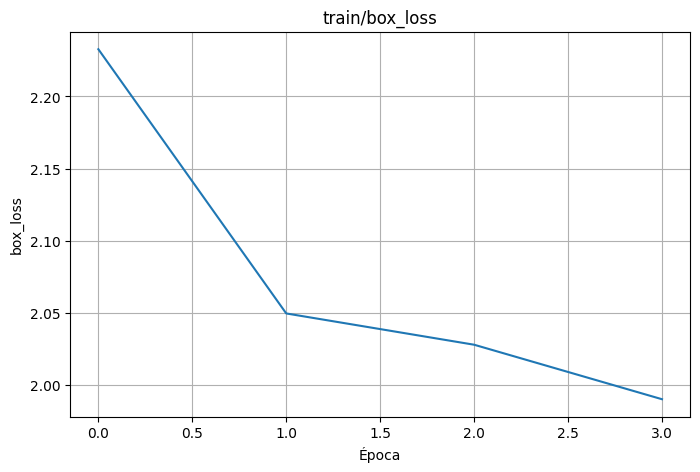

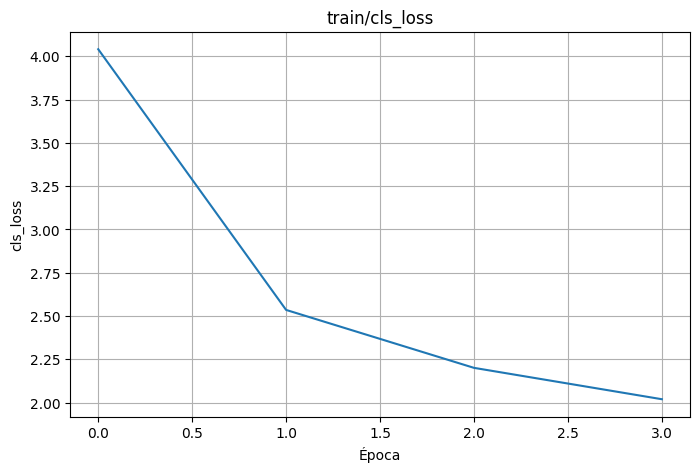

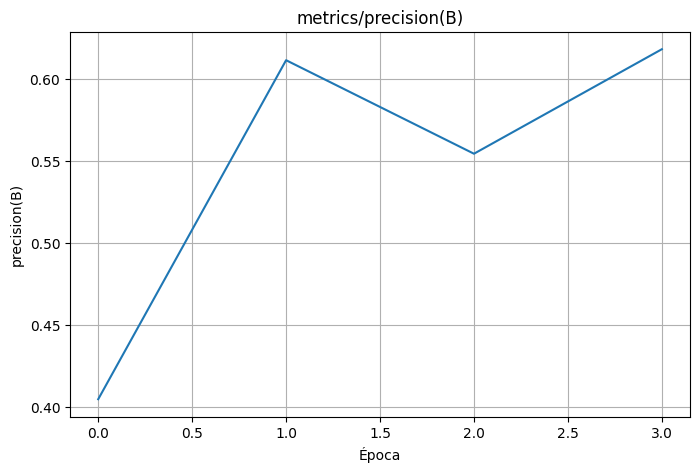

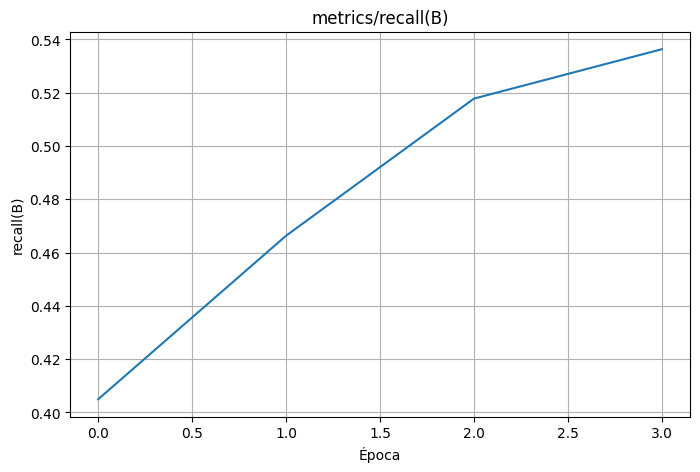

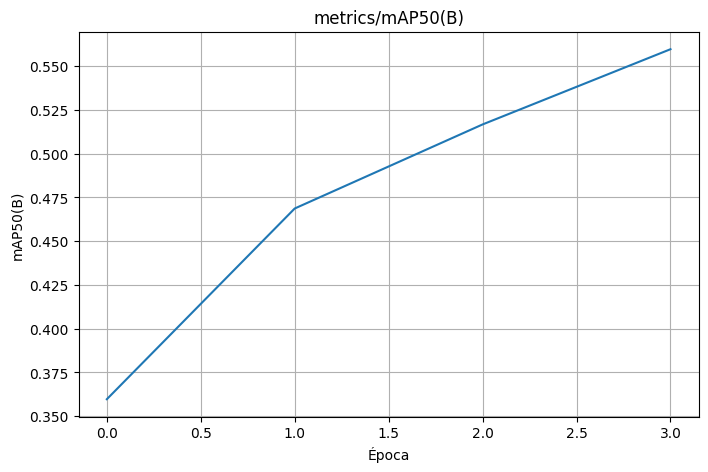

In [ ]:
# ======================================================
# VISUALIZAR RESULTADOS DEL ENTRENAMIENTO (vía CSV)
# ======================================================
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ruta al CSV de resultados
exp_dir = "/content/drive/MyDrive/Colab Notebooks/runs/baggage_yolov8n_debug"
csv_path = os.path.join(exp_dir, "results.csv")

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Resultados del entrenamiento cargados correctamente \n")
    print(df.head())

    # --- Graficar pérdidas y métricas ---
    metrics = ['train/box_loss', 'train/cls_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)']
    for metric in metrics:
        if metric in df.columns:
            plt.figure(figsize=(8, 5))
            plt.plot(df.index, df[metric])
            plt.title(metric)
            plt.xlabel("Época")
            plt.ylabel(metric.split('/')[-1])
            plt.grid(True)
            plt.show()
else:
    print("No se encontró results.csv — ejecutá el entrenamiento primero.")




In [ ]:
# Experimentos propuestos
# Propuesta de 4 entrenamientos (solo texto explicativo):

experimentos = {
    "EXP1": "YOLOv8n - 10 epochs - subset - baseline rápido",
    "EXP2": "YOLOv8s - 100 epochs - full dataset - augment moderado",
    "EXP3": "YOLOv8s - 100 epochs - sin augment - comparación",
    "EXP4": "Faster-RCNN ResNet50 FPN - pretrained COCO - 30 epochs"
}

for k,v in experimentos.items():
    print(f"{k}: {v}")



EXP1: YOLOv8n - 10 epochs - subset - baseline rápido
EXP2: YOLOv8s - 100 epochs - full dataset - augment moderado
EXP3: YOLOv8s - 100 epochs - sin augment - comparación
EXP4: Faster-RCNN ResNet50 FPN - pretrained COCO - 30 epochs


In [ ]:
# Guardar pesos y resultado en Drive
!cp -r /content/runs /content/drive/MyDrive/Colab\ Notebooks/
print("Resultados copiados a Drive en Colab Notebooks/runs/")




Resultados copiados a Drive en Colab Notebooks/runs/
